In [1]:
# 1. Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor


In [2]:
# 2. Read the CSV file and assign the 'Price' column to the variable df1
df = pd.read_csv('/Users/baoan/Desktop/STB-His-torical-Data-19.csv')
df1 = df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/19/2017,12400.0,12450.0,12550.0,12350.0,2.61M,-0.40%
1,05/22/2017,12700.0,12400.0,12900.0,12350.0,5.15M,2.42%
2,05/23/2017,12400.0,12800.0,12900.0,12400.0,3.42M,-2.36%
3,05/24/2017,12550.0,12500.0,12750.0,12400.0,2.94M,1.21%
4,05/25/2017,12400.0,12550.0,12750.0,12350.0,4.88M,-1.20%
...,...,...,...,...,...,...,...
1495,05/15/2023,27000.0,27000.0,27600.0,26900.0,29.85M,0.75%
1496,05/16/2023,27400.0,27000.0,27550.0,27000.0,13.15M,1.48%
1497,05/17/2023,27000.0,27400.0,27500.0,26900.0,17.69M,-1.46%
1498,05/18/2023,27200.0,27150.0,27500.0,27000.0,15.19M,0.74%


In [3]:
# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [4]:
# 4. Split the data into train, test, and validation sets
train_size = int(0.65 * len(df1))
test_size = int(0.25 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [5]:
# 5. Define the time step and create the dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 89
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
# 6. Reshape the input to be [samples, time steps]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [7]:
# 7. Define the KNN model
model = KNeighborsRegressor(n_neighbors=5)

In [8]:
# 8. Fit the model with the training data
model.fit(X_train, y_train)

KNeighborsRegressor()

In [9]:
# 9. Perform predictions on the validation set
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

In [10]:
ytest = scaler.inverse_transform(y_test.reshape(-1,1))
yval = scaler.inverse_transform(y_val.reshape(-1,1))

In [11]:
# 10. Calculate RMSE for validation set
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 25568.091789961447
Testing RMSE: 27302.84703258349


In [12]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.1931917211328979
Testing MAPE: 0.3246646026831787


In [13]:
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(actual_prices, predicted_prices)
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 25555.297431406892
Testing MAE: 26958.76234368759


In [14]:
# 11. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 89  # Adjusted to 89
i = 0
while i < 30:
    if len(temp_input) > 89:  # Adjusted to 89
        x_input = np.array(temp_input[-89:])  # Take the last 89 values
        x_input = x_input.reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [15]:
# Chuyển đổi các giá trị dự báo về tỷ giá gốc
predicted_values = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# 12. In dự báo 30 ngày tiếp theo
for i in range(30):
    print('Day {}: {}'.format(i+1, predicted_values[i][0]))

Day 1: 22600.0
Day 2: 22600.0
Day 3: 22600.0
Day 4: 22600.0
Day 5: 22600.0
Day 6: 22600.0
Day 7: 22600.0
Day 8: 22600.0
Day 9: 22600.0
Day 10: 22600.0
Day 11: 22600.0
Day 12: 22600.0
Day 13: 22600.0
Day 14: 22600.0
Day 15: 22600.0
Day 16: 22600.0
Day 17: 22600.0
Day 18: 22600.0
Day 19: 22600.0
Day 20: 22600.0
Day 21: 22600.0
Day 22: 22600.0
Day 23: 22600.0
Day 24: 22600.0
Day 25: 22600.0
Day 26: 22600.0
Day 27: 22600.0
Day 28: 22600.0
Day 29: 22600.0
Day 30: 22600.0


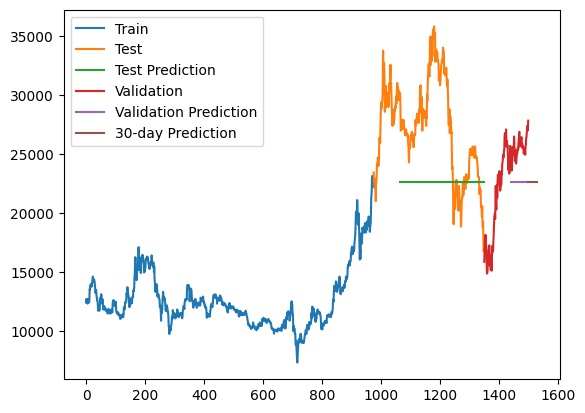

In [16]:

# Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data).flatten())

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data).flatten())

test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten())

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data).flatten())

val_pred_index = pd.RangeIndex(start=train_size + test_size + time_step, stop=train_size + test_size + time_step + len(y_pred_val), step=1)
plt.plot(val_pred_index, scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten())

predict_index = pd.RangeIndex(start=len(df1), stop=len(df1) + len(predicted_values), step=1)
plt.plot(predict_index, predicted_values.flatten())

plt.legend(['Train', 'Test', 'Test Prediction', 'Validation', 'Validation Prediction', '30-day Prediction'])
plt.show()

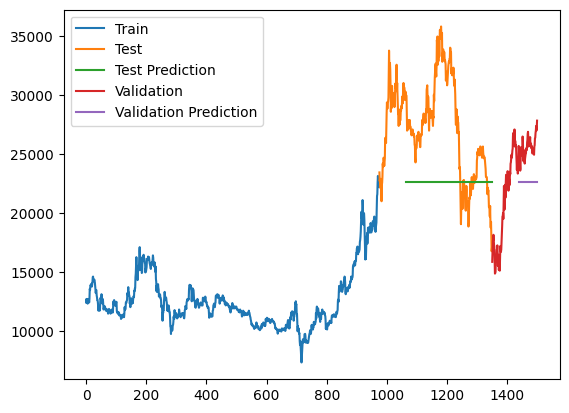

In [17]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data).flatten())

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data).flatten())

test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten())

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data).flatten())

val_pred_index = pd.RangeIndex(start=train_size + test_size + time_step, stop=train_size + test_size + time_step + len(y_pred_val), step=1)
plt.plot(val_pred_index, scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten())


plt.legend(['Train', 'Test', 'Test Prediction', 'Validation', 'Validation Prediction'])
plt.show()

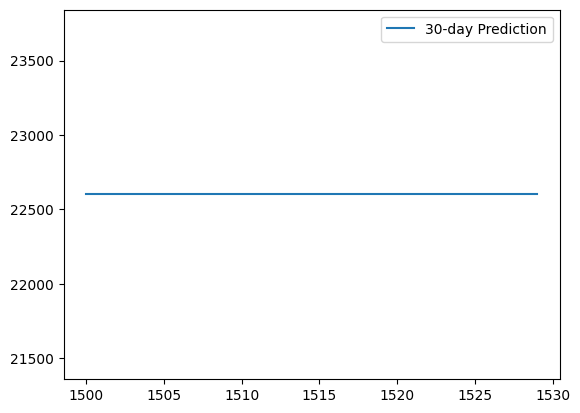

In [18]:

predict_index = pd.RangeIndex(start=len(df1), stop=len(df1) + len(predicted_values), step=1)
plt.plot(predict_index, predicted_values.flatten())

plt.legend(['30-day Prediction'])
plt.show()